<a href="https://colab.research.google.com/github/VedangPaithankar/CMKD-for-Morse-Code-Translation/blob/main/CNN%2C_RNN%2C_CNN_RNN_Hybrid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [18]:
import os
import numpy as np
import librosa
import cv2
import tensorflow as tf
from tensorflow.keras import layers, models, regularizers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder

In [24]:
def audio_to_spectrogram(file_path, n_mels=64, n_fft=2048, hop_length=512):
    """Convert audio file to mel spectrogram"""
    y, sr = librosa.load(file_path, sr=None)
    spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_mels=n_mels, n_fft=n_fft, hop_length=hop_length)
    log_spectrogram = librosa.power_to_db(spectrogram)
    return log_spectrogram

def get_label_from_filename(filename):
    """Extract label from filename, handling both letter and number cases"""
    base_name = filename.split('_')[0]  # Remove _new suffix if present
    base_name = base_name.split('.')[0]  # Remove file extension
    return base_name

def initialize_label_encoder():
    """Initialize label encoder with all possible classes"""
    labels = [chr(i) for i in range(ord('A'), ord('Z')+1)]  # A-Z
    labels.extend([str(i) for i in range(1, 10)])  # 1-9
    label_encoder = LabelEncoder()
    label_encoder.fit(labels)
    return label_encoder

def preprocess_audio_file(file_path, target_size=(64, 64)):
    """Preprocess a single audio file"""
    try:
        # Generate spectrogram
        spectrogram = audio_to_spectrogram(file_path)

        # Resize to target size
        spectrogram_resized = cv2.resize(spectrogram, target_size)

        # Normalize
        spectrogram_normalized = (spectrogram_resized - spectrogram_resized.min()) / \
                               (spectrogram_resized.max() - spectrogram_resized.min())

        return spectrogram_normalized[..., np.newaxis]  # Add channel dimension
    except Exception as e:
        print(f"Error processing file {file_path}: {e}")
        return None

def load_dataset(data_dir, label_encoder=None):
    """Load and preprocess the entire dataset"""
    if label_encoder is None:
        label_encoder = initialize_label_encoder()

    X = []
    y = []
    skipped_files = []

    for filename in os.listdir(data_dir):
        if filename.endswith('.wav'):
            file_path = os.path.join(data_dir, filename)
            label = get_label_from_filename(filename)

            # Skip if label not in our label set
            if label not in label_encoder.classes_:
                skipped_files.append(filename)
                continue

            # Process audio file
            processed_audio = preprocess_audio_file(file_path)
            if processed_audio is not None:
                X.append(processed_audio)
                y.append(label)

    if skipped_files:
        print(f"Skipped {len(skipped_files)} files with unknown labels: {skipped_files}")

    X = np.array(X)
    y = label_encoder.transform(y)

    return X, y, label_encoder

In [25]:
def create_cnn_model(input_shape, num_classes):
    """Create CNN model"""
    model = models.Sequential([
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(256, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Flatten(),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_rnn_model(input_shape, num_classes):
    """Create RNN model"""
    model = models.Sequential([
        layers.Reshape((input_shape[0], input_shape[1]), input_shape=input_shape),
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

def create_cnn_rnn_model(input_shape, num_classes):
    """Create CNN-RNN hybrid model"""
    model = models.Sequential([
        # CNN layers
        layers.Conv2D(64, (3, 3), activation='relu', input_shape=input_shape),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        layers.Conv2D(128, (3, 3), activation='relu'),
        layers.BatchNormalization(),
        layers.MaxPooling2D((2, 2)),

        # Prepare for RNN
        layers.Reshape((-1, 128)),  # Reshape to sequence

        # RNN layers
        layers.LSTM(128, return_sequences=True),
        layers.LSTM(64),

        # Dense layers
        layers.Dense(256, activation='relu', kernel_regularizer=regularizers.l2(0.01)),
        layers.BatchNormalization(),
        layers.Dropout(0.5),
        layers.Dense(num_classes, activation='softmax')
    ])
    return model

# Training Functions
def train_models(train_data_dir, test_data_dir, save_dir):
    """Train all models"""
    # Load and preprocess data
    print("Loading and preprocessing data...")
    X_train, y_train, label_encoder = load_dataset(train_data_dir)
    X_test, y_test, _ = load_dataset(test_data_dir, label_encoder)

    input_shape = (64, 64, 1)
    num_classes = len(label_encoder.classes_)

    # Training parameters
    epochs = 200
    batch_size = 32

    # Dictionary to store training histories
    histories = {}

    # Train CNN
    print("\nTraining CNN model...")
    cnn_model = create_cnn_model(input_shape, num_classes)
    cnn_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
    histories['CNN'] = cnn_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    ).history
    cnn_model.save(os.path.join(save_dir, 'cnn_model.h5'))

    # Train RNN
    print("\nTraining RNN model...")
    rnn_model = create_rnn_model(input_shape, num_classes)
    rnn_model.compile(optimizer='adam',
                     loss='sparse_categorical_crossentropy',
                     metrics=['accuracy'])
    histories['RNN'] = rnn_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    ).history
    rnn_model.save(os.path.join(save_dir, 'rnn_model.h5'))

    # Train CNN-RNN
    print("\nTraining CNN-RNN model...")
    cnn_rnn_model = create_cnn_rnn_model(input_shape, num_classes)
    cnn_rnn_model.compile(optimizer='adam',
                         loss='sparse_categorical_crossentropy',
                         metrics=['accuracy'])
    histories['CNN-RNN'] = cnn_rnn_model.fit(
        X_train, y_train,
        epochs=epochs,
        batch_size=batch_size,
        validation_data=(X_test, y_test),
        verbose=1
    ).history
    cnn_rnn_model.save(os.path.join(save_dir, 'cnn_rnn_model.h5'))

    # Plot training histories
    plot_training_histories(histories)

    return histories, label_encoder

def plot_training_histories(histories):
    """Plot training histories for all models"""
    plt.figure(figsize=(15, 5))

    # Plot accuracy
    plt.subplot(1, 2, 1)
    for model_name, history in histories.items():
        plt.plot(history['accuracy'], label=f'{model_name} Train')
        plt.plot(history['val_accuracy'], label=f'{model_name} Val')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()

    # Plot loss
    plt.subplot(1, 2, 2)
    for model_name, history in histories.items():
        plt.plot(history['loss'], label=f'{model_name} Train')
        plt.plot(history['val_loss'], label=f'{model_name} Val')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    plt.tight_layout()
    plt.show()

In [26]:
def evaluate_model(model_name, model_path, test_data_dir):
    """Evaluate a single model"""
    try:
        # Load model and initialize label encoder
        model = load_model(model_path)
        label_encoder = initialize_label_encoder()

        # Load test data
        X_test, y_test, _ = load_dataset(test_data_dir, label_encoder)

        # Evaluate model
        predictions = model.predict(X_test)
        predicted_labels = label_encoder.inverse_transform(np.argmax(predictions, axis=1))
        true_labels = label_encoder.inverse_transform(y_test)

        # Calculate accuracy
        correct = np.sum(predicted_labels == true_labels)
        total = len(true_labels)
        accuracy = (correct / total) * 100

        print(f"\nResults for {model_name}:")
        print(f"Accuracy: {accuracy:.2f}% ({correct}/{total})")

        # Print confusion matrix
        from sklearn.metrics import confusion_matrix, classification_report
        print("\nClassification Report:")
        print(classification_report(true_labels, predicted_labels))

        return accuracy

    except Exception as e:
        print(f"An error occurred with model {model_name}: {e}")
        return None

def evaluate_all_models(model_paths, test_data_dir):
    """Evaluate all models"""
    results = {}
    for model_name, model_path in model_paths.items():
        print(f"\nEvaluating {model_name} model...")
        accuracy = evaluate_model(model_name, model_path, test_data_dir)
        results[model_name] = accuracy

    print("\nFinal Results:")
    for model_name, accuracy in results.items():
        if accuracy is not None:
            print(f"{model_name}: {accuracy:.2f}%")
        else:
            print(f"{model_name}: Failed to evaluate")

Starting model training...
Loading and preprocessing data...
Skipped 2 files with unknown labels: ['0_new.wav', '0.wav']
Skipped 2 files with unknown labels: ['0_new.wav', '0.wav']

Training CNN model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 13s 3s/step - accuracy: 0.0299 - loss: 10.0852 - val_accuracy: 0.1000 - val_loss: 8.4611
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 28ms/step - accuracy: 0.2360 - loss: 7.7503 - val_accuracy: 0.0429 - val_loss: 8.4152
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.3504 - loss: 7.2816 - val_accuracy: 0.0286 - val_loss: 8.3697
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.4285 - loss: 6.9864 - val_accuracy: 0.0286 - val_loss: 8.3350
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 28ms/step - accuracy: 0.5819 - loss: 6.3532 - val_accuracy: 0.0286 - val_loss: 8.3177
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - accuracy: 0.4883 - loss: 6.5561 - val_accuracy: 0.0286 - val_loss: 8.3158
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 29ms/step - accuracy: 0.6314 - loss: 6.1367 - val_accuracy: 0.0286 - val_loss: 8.3457
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - accuracy: 0.7243 - loss: 5.8018 - val_accuracy: 0.0286 - val_loss:


Training RNN model...


/usr/local/lib/python3.10/dist-packages/keras/src/layers/reshaping/reshape.py:39: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 220ms/step - accuracy: 0.0299 - loss: 4.6258 - val_accuracy: 0.0571 - val_loss: 4.5425
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.0221 - loss: 4.5098 - val_accuracy: 0.0571 - val_loss: 4.5114
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - accuracy: 0.0819 - loss: 4.3848 - val_accuracy: 0.0714 - val_loss: 4.4839
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.0656 - loss: 4.3116 - val_accuracy: 0.1000 - val_loss: 4.4589
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1567 - loss: 4.1500 - val_accuracy: 0.1143 - val_loss: 4.4346
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.1541 - loss: 4.0781 - val_accuracy: 0.1286 - val_loss: 4.4100
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - accuracy: 0.1489 - loss: 3.9948 - val_accuracy: 0.1286 - val_loss: 4.3862
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - accuracy: 0.1677 - loss: 3.8689 - val_accuracy: 0.1000 - val_loss


Training CNN-RNN model...
Epoch 1/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 5s 345ms/step - accuracy: 0.0299 - loss: 4.6369 - val_accuracy: 0.0286 - val_loss: 4.5402
Epoch 2/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step - accuracy: 0.0000e+00 - loss: 4.5355 - val_accuracy: 0.0286 - val_loss: 4.5121
Epoch 3/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 71ms/step - accuracy: 0.0189 - loss: 4.5392 - val_accuracy: 0.0286 - val_loss: 4.4857
Epoch 4/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step - accuracy: 0.0442 - loss: 4.3805 - val_accuracy: 0.0286 - val_loss: 4.4610
Epoch 5/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 83ms/step - accuracy: 0.0520 - loss: 4.3410 - val_accuracy: 0.0286 - val_loss: 4.4375
Epoch 6/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 76ms/step - accuracy: 0.0559 - loss: 4.3239 - val_accuracy: 0.0286 - val_loss: 4.4157
Epoch 7/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step - accuracy: 0.0598 - loss: 4.2937 - val_accuracy: 0.0286 - val_loss: 4.3956
Epoch 8/200
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step - accuracy: 0.1353 - loss: 4.1743 - 

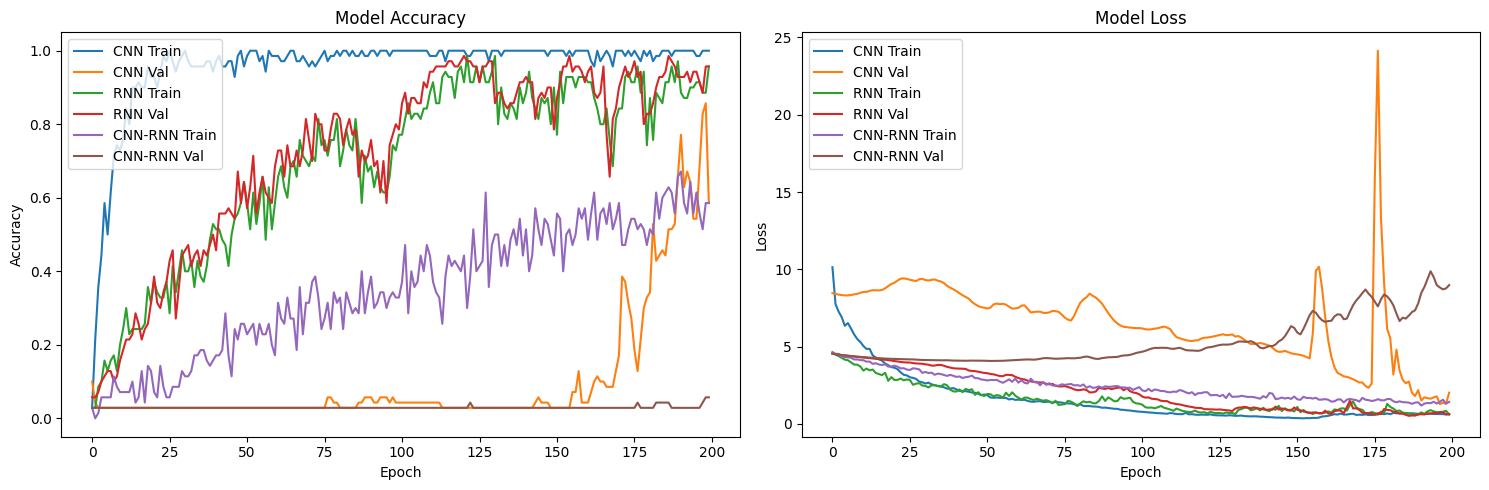


Starting model evaluation...

Evaluating CNN-RNN model...
Skipped 2 files with unknown labels: ['0_new.wav', '0.wav']
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 198ms/step

Results for CNN-RNN:
Accuracy: 5.71% (4/70)

Classification Report:
              precision    recall  f1-score   support

           1       0.00      0.00      0.00         2
           2       0.00      0.00      0.00         2
           3       0.00      0.00      0.00         2
           4       0.00      0.00      0.00         2
           5       0.00      0.00      0.00         2
           6       0.00      0.00      0.00         2
           7       0.00      0.00      0.00         2
           8       0.00      0.00      0.00         2
           9       0.00      0.00      0.00         2
           A       0.00      0.00      0.00         2
           B       0.06      1.00      0.11         2
           C       0.00      0.00      0.00         2
           D       0.06      1.00      0.11         2
           E    

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


Skipped 2 files with unknown labels: ['0_new.wav', '0.wav']
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 100ms/step

Results for RNN:
Accuracy: 95.71% (67/70)

Classification Report:
              precision    recall  f1-score   support

           1       1.00      1.00      1.00         2
           2       0.67      1.00      0.80         2
           3       0.67      1.00      0.80         2
           4       1.00      1.00      1.00         2
           5       1.00      1.00      1.00         2
           6       1.00      1.00      1.00         2
           7       1.00      1.00      1.00         2
           8       1.00      0.50      0.67         2
           9       1.00      1.00      1.00         2
           A       0.67      1.00      0.80         2
           B       1.00      1.00      1.00         2
           C       1.00      1.00      1.00         2
           D       1.00      1.00      1.00         2
           E       1.00      1.00      1.00         2
           F       1.00

Skipped 2 files with unknown labels: ['0_new.wav', '0.wav']
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 163ms/step

Results for CNN:
Accuracy: 58.57% (41/70)

Classification Report:
              precision    recall  f1-score   support

           1       0.12      1.00      0.22         2
           2       0.00      0.00      0.00         2
           3       0.67      1.00      0.80         2
           4       1.00      0.50      0.67         2
           5       1.00      0.50      0.67         2
           6       0.50      0.50      0.50         2
           7       1.00      0.50      0.67         2
           8       1.00      1.00      1.00         2
           9       1.00      0.50      0.67         2
           A       1.00      1.00      1.00         2
           B       1.00      1.00      1.00         2
           C       0.00      0.00      0.00         2
           D       0.00      0.00      0.00         2
           E       0.67      1.00      0.80         2
           F       1.00

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


In [27]:
train_data_dir = "/content/drive/MyDrive/Project I/training_data"
test_data_dir = "/content/drive/MyDrive/Project I/training_data"
save_dir = "/content/drive/MyDrive/Project I/saved_model"

os.makedirs(save_dir, exist_ok=True)

# Train models
print("Starting model training...")
histories, label_encoder = train_models(train_data_dir, test_data_dir, save_dir)

# Define model paths
model_paths = {
    "CNN-RNN": os.path.join(save_dir, "cnn_rnn_model.h5"),
    "RNN": os.path.join(save_dir, "rnn_model.h5"),
    "CNN": os.path.join(save_dir, "cnn_model.h5")
}

# Evaluate models
print("\nStarting model evaluation...")
evaluate_all_models(model_paths, test_data_dir)

In [28]:
def evaluate_rnn_detailed(model_path, test_data_dir):
    """Evaluate RNN model with detailed predictions"""
    try:
        # Load model and initialize label encoder
        model = load_model(model_path)
        label_encoder = initialize_label_encoder()

        # Get list of test files and their actual labels
        test_files = [f for f in os.listdir(test_data_dir) if f.endswith('.wav')]

        # Create lists to store results
        results = []

        # Process each file
        for filename in test_files:
            file_path = os.path.join(test_data_dir, filename)
            # Get actual label
            true_label = get_label_from_filename(filename)

            # Process audio file
            processed_audio = preprocess_audio_file(file_path)
            if processed_audio is not None:
                # Make prediction
                prediction = model.predict(np.array([processed_audio]), verbose=0)
                predicted_label = label_encoder.inverse_transform([np.argmax(prediction)])[0]

                # Store result
                results.append({
                    'file_name': filename,
                    'predicted_label': predicted_label,
                    'true_label': true_label,
                    'correct': predicted_label == true_label
                })

        # Print results table
        print("\nDetailed Prediction Results:")
        print("-" * 70)
        print(f"{'File Name':<30} {'Predicted Label':<15} {'Correct/Incorrect':<15}")
        print("-" * 70)

        correct_count = 0
        total_count = len(results)

        for result in results:
            status = "Correct" if result['correct'] else "Incorrect"
            print(f"{result['file_name']:<30} {result['predicted_label']:<15} {status:<15}")
            if result['correct']:
                correct_count += 1

        print("-" * 70)
        accuracy = (correct_count / total_count) * 100
        print(f"\nFinal Accuracy: {accuracy:.2f}% ({correct_count}/{total_count} correct)")

        return results, accuracy

    except Exception as e:
        print(f"An error occurred during evaluation: {e}")
        return None, None

test_data_dir = "/content/drive/MyDrive/Project I/training_data"
rnn_model_path = "/content/drive/MyDrive/Project I/saved_model/rnn_model.h5"

print("Evaluating RNN model with detailed results...")
results, accuracy = evaluate_rnn_detailed(rnn_model_path, test_data_dir)

Evaluating RNN model with detailed results...

Detailed Prediction Results:
----------------------------------------------------------------------
File Name                      Predicted Label Correct/Incorrect
----------------------------------------------------------------------
8.wav                          8               Correct        
6.wav                          6               Correct        
L_new.wav                      L               Correct        
A_new.wav                      A               Correct        
G_new.wav                      G               Correct        
C.wav                          C               Correct        
D.wav                          D               Correct        
F.wav                          F               Correct        
1_new.wav                      1               Correct        
F_new.wav                      F               Correct        
J.wav                          J               Correct        
B_new.wav               